# RAG with Embeddings

In this lab guide, we will go through the core steps of a Retrieval-Augmented Generation (RAG) workflow using embeddings. Starting from the user's question, the process involves preparing documents, generating embeddings, computing similarities to retrieve relevant passages, and finally prompting a large language model (LLM) to generate an answer. We will explore how AI systems use vector representations for semantic search and response generation.

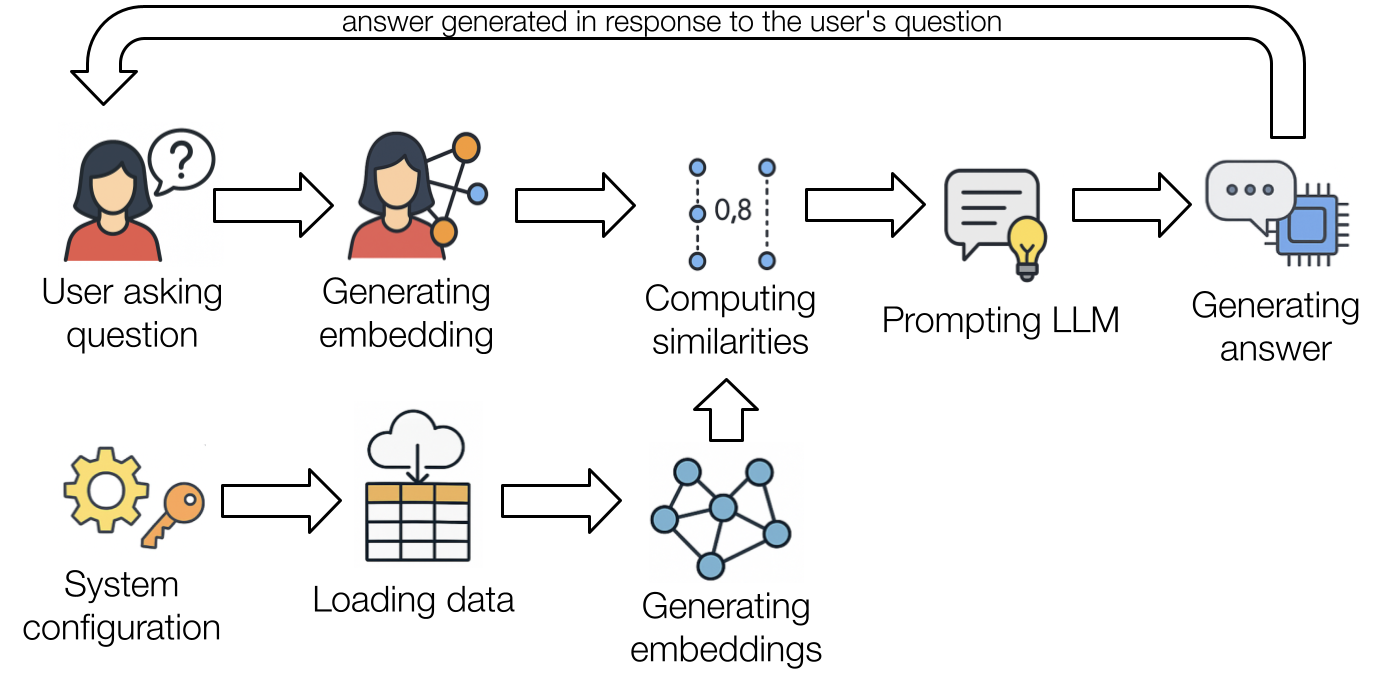

## Configuration

Let's start by setting up the environment in Google Colab by importing key libraries, authenticating the user, and authorizing access to Google Sheets.

In [39]:
QUESTIONS = [
    {
        "question": "How many times can I repeat a semester?",
        "answer": "A semester of studies may be repeated only once at each level of studies or in justified case twice."
    },
    {
        "question": "Do I have to be insured as an international student?",
        "answer": "As an international student, you must have health insurance under the National Health Fund (abbreviation in Polish: NFZ) or travel medical insurance."
    },
    {
        "question": "What do I have to do to be awarded with a distinction while graduating?",
        "answer": "You need to recieve very good grades for both the diploma project or the diploma thesis and the diploma examination and the grade point average for studies of at least 4,72."
    },
    {
        "question": "How many faculties there are on AGH University of Science?",
        "answer": "AGH University of Science and Technology has 16 faculties as of the latest available data."
    },
    {
        "question": "How many second-cycle programmes are there on Faculty of Electrical Engineering, Automatics, Computer Science and Biomedical Engineering",
        "answer": "There are 9 second-cycle programmes offered by the Faculty of Electrical Engineering, Automatics, Computer Science and Biomedical Engineering at AGH University."
    },
    {
        "question": "What scholarship are available at AGH and do I have to have medical insurance as non-EU and non-EFTA international student?",
        "answer": "Rector's scholarship, scholarship for disabled people, social scholarship, aid for the students in need. You have to pay for medical care."
    },

]

NUMBER = 5
READ_FROM_FILE = False

In [40]:
import os
import sys
import logging
import numpy as np

Let's configure logging to display messages in the Colab console:

In [41]:
# Set up logging to output to the standard output (stdout)
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # or any other level

# Create console handler with a higher log level
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)  # Adjust as necessary

# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(console_handler)

Now, we need to set up access to the Generative AI API by configuring the Google API key and specifying two models: one for generating embeddings and another for text generation tasks.

In [42]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=api_key)

EMBEDDING_MODEL = 'models/embedding-001'
GENERATION_MODEL = 'gemini-1.5-flash-8b'

## Loading data

Load data from a shared Google Sheet by URL:

In [43]:
import re
import pandas as pd

# Load text file
with open("data/2023_10_01_RS_ENG.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Split using regex pattern for section titles like: § 1., § 2A., § 12.
parts = re.split(r"(§\s*\d+[A-Za-z]?\.\s+[A-Z \-]+)", text)

sections = []
for i in range(1, len(parts), 2):
    title = parts[i].strip()
    content = parts[i+1].strip() if i+1 < len(parts) else ""
    sections.append({"Title": title, "Content": content})

df = pd.DataFrame(sections)

df.to_csv("data/parsed_sections.csv", index=False)

print(df.head())


                                 Title  \
0                    § 1. INTRODUCTION   
1             § 2. GENERAL REGULATIONS   
2       § 3. STUDIES AT THE UNIVERSITY   
3            § 4. ADMISSION TO STUDIES   
4  § 5. STUDENT RIGHTS AND OBLIGATIONS   

                                             Content  
0  1.\n\nThe AGH University of Krakow Study Regul...  
1  1.\n\nStudents, doctoral students and employee...  
2  1.\n\nStudies at the University are conducted ...  
3  1.\n\nAdmission to studies shall take place th...  
4  1.\n\nA student shall have the right to:\n1)\n...  


## Generating embeddings

Generate embeddings for each document by iterating through the DataFrame rows and applying a function that uses the document's title and content with a retrieval-optimized embedding model:

In [44]:
if not READ_FROM_FILE:
  def embed_document(title, content):
      response = genai.embed_content(
          model=EMBEDDING_MODEL,
          content=content,
          task_type="retrieval_document",
          title=title
      )
      return response["embedding"]

  df['Embedding'] = [
      embed_document(row.Title, row.Content) for row in df.itertuples(index=False)
  ]
  df.to_pickle("embeddings.pkl")
else:
  df = pd.read_pickle("embeddings.pkl")

Generate an embedding for a question:

In [45]:
# question = "What is the Erasmus+ application deadline for the Faculty of Electrical Engineering, Automatics, Computer Science, and Biomedical Engineering?" # April 11, 2025
# question = "What is the deadline for submitting the master thesis if the classes ends in June?" # September 30, 2025
# question = "What is the deadline for passing my exams if the classes ends in June?" # September 14, 2025
question = QUESTIONS[NUMBER]["question"]

request = genai.embed_content(model=EMBEDDING_MODEL,
                              content=question,
                              task_type="retrieval_query")

question_embedding = request["embedding"]

In [46]:
print(question_embedding)

[0.032452434, -0.036158286, -0.012665876, -0.020859117, 0.06924431, 0.0023893344, 0.027617978, 0.001616629, -0.029038897, 0.061242808, 0.0066869496, 0.039843377, 0.006513064, 0.013036262, -0.039634652, -0.02678374, 0.024692053, 0.0057017263, 0.042493697, -0.07063928, 0.026424106, 0.04994206, -0.005425319, -0.03712055, 0.008447233, -0.08574325, 0.0011232352, 0.023669751, -0.042189967, 0.011241682, -0.06728192, 0.004336784, -0.06810575, -0.00030401596, 0.013151133, -0.03901411, 0.015072288, 0.013422104, -0.06446657, 0.044893503, 0.022637816, -0.0029317471, -0.043727707, -0.031411577, -0.0065316875, 0.0036358945, -0.009503008, 0.048713516, 0.0046715317, -0.080735, -0.03710838, 0.018074783, 0.04484931, -0.014295323, 0.00072333275, -0.063682966, 0.019342247, -0.029171454, -0.005499319, 0.0035601198, 0.020361241, -0.034611546, -0.039095417, 0.08173727, -0.023813885, -0.006924473, 0.03540851, 0.012502621, 0.03859869, -0.016507585, 0.013880582, -0.023839578, 0.026644532, -0.03437618, -0.024626

## Computing similarity

First, let's compute the cosine similarity between the query embedding and a single document to understand the similarity logic:

In [47]:
v1 = np.array(question_embedding)
v2 = df.loc[2, 'Embedding']
cos_sim = np.dot(v1, v2)
print("Cosine similarity:", cos_sim)

Cosine similarity: 0.5246215064883766


A **cosine similarity** of `0.78` indicates a **strong semantic similarity** between the query and the document.

🔍 What does it mean? Cosine similarity ranges from **-1 to 1**:
- `1.0` → perfect match (identical direction)
- `0.0` → no similarity (orthogonal vectors)
- `-1.0` → completely opposite meaning

In our case a value of `0.78` suggests that the document is **closely aligned** with the query in meaning and it is likely a **relevant and appropriate match** for the user's question.


Now, we will calculate dot products between the query and all document embeddings to identify the most relevant match. The document with the highest score is selected as the best answer.

In [48]:
dot_products = np.dot(np.stack(df['Embedding']), question_embedding)
logging.info(f"Dot products (cosine similarities): {dot_products}")

top_indices = np.argsort(dot_products)[-3:][::-1]
logging.info(f"Indices of the top 3 most similar documents: {top_indices}")

top_passages = df.iloc[top_indices]['Content'].tolist()
top_passage = df.iloc[top_indices[0]]['Content']

2025-06-09 10:49:49,698 - INFO - Dot products (cosine similarities): [0.58343661 0.63953252 0.52462151 0.52372679 0.56670826 0.5449482
 0.61577655 0.5268311  0.54932235 0.50276495 0.62055358 0.53010984
 0.4964699  0.52230765 0.49550896 0.51060641 0.5018651  0.52402256
 0.47271752 0.50522444 0.55521655 0.51868849 0.48858126 0.60519448
 0.54213146 0.51971049 0.50579766 0.51406313 0.49266487 0.59555168
 0.48704282 0.48071802 0.58583861 0.58109237 0.57062587]
2025-06-09 10:49:49,698 - INFO - Dot products (cosine similarities): [0.58343661 0.63953252 0.52462151 0.52372679 0.56670826 0.5449482
 0.61577655 0.5268311  0.54932235 0.50276495 0.62055358 0.53010984
 0.4964699  0.52230765 0.49550896 0.51060641 0.5018651  0.52402256
 0.47271752 0.50522444 0.55521655 0.51868849 0.48858126 0.60519448
 0.54213146 0.51971049 0.50579766 0.51406313 0.49266487 0.59555168
 0.48704282 0.48071802 0.58583861 0.58109237 0.57062587]
2025-06-09 10:49:49,698 - INFO - Dot products (cosine similarities): [0.58343661

In [49]:
top_passages

["1.\n\nStudents, doctoral students and employees of the University constitute the community of the University; as\nits members, they co-decide about the University’s affairs and are jointly responsibility for the performance\nof its tasks.\n\n2.\n\nAll decisions taken pursuant to the Study Regulations shall result from understanding the needs, rights and\nobligations of the academic youth and shall be consistent with the common good, with the Act and with the\nStatute.\n\n3.\n\nThe Rector is the superior of the students at the University, and the Dean – at the faculty.\n\n3a. The Student Ombudsman shall protect student rights and obligations set out in the Study Regulations and\nin other regulations in force at the University.\n3b. The scope and manner of operation of the Student Ombudsman shall be determined by the Rector by way\nof an order.\n4.\n\nAdministrative decisions and in-house settlements which are not administrative decisions (so-called\nsettlements) shall be issued in stu

## Prompting LLM

Let's define a prompt includeing the user's question and the most relevant passage:

In [50]:
PROMPT= f"""You are a helpful and informative AGH bot that answers questions using the reference passage provided below.
If the passage is not relevant to the question, you may ignore it.
QUESTION: '{question}'
PASSAGES: '{top_passages}'
ANSWER: """

In [51]:
print(PROMPT)

You are a helpful and informative AGH bot that answers questions using the reference passage provided below.
If the passage is not relevant to the question, you may ignore it.
QUESTION: 'What scholarship are available at AGH and do I have to have medical insurance as non-EU and non-EFTA international student?'
PASSAGES: '["1.\n\nStudents, doctoral students and employees of the University constitute the community of the University; as\nits members, they co-decide about the University’s affairs and are jointly responsibility for the performance\nof its tasks.\n\n2.\n\nAll decisions taken pursuant to the Study Regulations shall result from understanding the needs, rights and\nobligations of the academic youth and shall be consistent with the common good, with the Act and with the\nStatute.\n\n3.\n\nThe Rector is the superior of the students at the University, and the Dean – at the faculty.\n\n3a. The Student Ombudsman shall protect student rights and obligations set out in the Study Regul

In [52]:
model = genai.GenerativeModel(GENERATION_MODEL)
response = model.generate_content(PROMPT)
answer = response.text

In [53]:
print(answer)

The provided text discusses university regulations, student rights, and class schedules.  It does not contain information about scholarships available at AGH or medical insurance requirements for international students.


Prompt without passage:

In [54]:
PROMPT= f"""You are a helpful and informative AGH bot that answers questions provided below.
QUESTION: '{question}'
ANSWER: """
model = genai.GenerativeModel(GENERATION_MODEL)
response = model.generate_content(PROMPT)
answer = response.text
print(answer)

Unfortunately, I do not have access to a real-time, comprehensive list of scholarships available at AGH University of Science and Technology.  Scholarship opportunities change frequently.  To find the current scholarships, you should visit the official AGH website.  Look for sections on "Scholarships," "Funding Opportunities," or similar headings.

Regarding medical insurance, you should also check the official AGH website, specifically the section for international students.  This is the definitive source for admission requirements, which will include whether or not medical insurance is mandatory.  Contacting the international student office at AGH directly is also a good idea.


Prompt with just one passage

In [55]:
PROMPT= f"""You are a helpful and informative AGH bot that answers questions provided below.
QUESTION: '{question}'
ASSAGES: '{top_passage}'
ANSWER: """
model = genai.GenerativeModel(GENERATION_MODEL)
response = model.generate_content(PROMPT)
answer = response.text
print(answer)

The provided text describes the organizational structure and procedures of AGH University of Science and Technology, but it does **not** contain information about scholarships or the requirement for medical insurance for international students.  Therefore, I cannot answer the question based on the given text.


## 🔧 Exercises

### 📚 1. Extend the Document Set
Select at least five additional questions from the question base and prepare suitable documents needed to answer them.  
Add these documents to the corpus (e.g., from another sheet or dataset) and re-run the pipeline.

### 🔁 2. Implement Caching for Embeddings
Avoid re-generating embeddings each time the notebook is run by saving and loading them from a file or sheet.

### 🤔 3. Answer Without Retrieval
Prompt the LLM with the question alone (without any retrieved passage) and compare the result to the RAG-based answer.

### 🔍 4. Experiment with Similarity Thresholds and Top-k Retrieval
For some questions, a single passage may not be enough.  
Identify such questions and try retrieving multiple passages — for example, use the top-3 most similar ones or apply a similarity threshold (e.g., 0.7) to include all passages above that value.  
If no such questions are found, use multiple questions to test the method.  
Evaluate whether this improves the quality of the answers.

### 🧪 5. Evaluate Answers
Based on the selected questions and expected answers, define simple metrics to automatically evaluate answer quality (e.g., keyword overlap or other heuristic-based scoring).

### 🧾 6. Log & Reflect
Document cases where the RAG pipeline failed or produced misleading answers, and reflect on possible reasons why.

### 📊 7. Visualize the Embedding Space
Use PCA or t-SNE to reduce the dimensionality of the embeddings and plot them to observe how similar documents are clustered in the vector space.

### Deadline

A group report should be submitted by Ms Teams till 05.06.2025.

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score

In [57]:
def tokenize(text):
    return set(re.findall(r'\b\w+\b', text.lower()))

def keyword_overlap_score(predicted, reference):
    pred_tokens = tokenize(predicted)
    ref_tokens = tokenize(reference)

    PROMPT= f"""You are an evaluator. Your task is to decide if the model response contains information from the reference answer.
      Ignore differences in grammar, phrasing, paraphrazing or extra clarifications or information.
      If the answer contradicts the reference, answer No. If the meaning contains the information in reference, answer Yes.

    response: '{pred_tokens}'
    reference: '{ref_tokens}'
    ANSWER: """
    model = genai.GenerativeModel(GENERATION_MODEL)
    response = model.generate_content(PROMPT)
    answer = response.text


    intersection = pred_tokens & ref_tokens
    union = pred_tokens | ref_tokens

    precision = len(intersection) / len(pred_tokens) if pred_tokens else 0
    recall = len(intersection) / len(ref_tokens) if ref_tokens else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    jaccard = len(intersection) / len(union) if union else 0

    return {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1 Score": round(f1, 3),
        "Jaccard": round(jaccard, 3),
        "Answer": answer
    }

In [58]:
generated_answer = answer
expected_answer = QUESTIONS[NUMBER]["answer"]

scores = keyword_overlap_score(generated_answer, expected_answer)

print(f"Expected Answer: {expected_answer}")
print(f"Generated Answer: {generated_answer}")
print("Evaluation Metrics:", scores)

Expected Answer: Rector's scholarship, scholarship for disabled people, social scholarship, aid for the students in need. You have to pay for medical care.
Generated Answer: The provided text describes the organizational structure and procedures of AGH University of Science and Technology, but it does **not** contain information about scholarships or the requirement for medical insurance for international students.  Therefore, I cannot answer the question based on the given text.

Evaluation Metrics: {'Precision': 0.111, 'Recall': 0.222, 'F1 Score': 0.148, 'Jaccard': 0.08, 'Answer': 'No\n'}


In [59]:
failure_log = []

for i, q in enumerate(QUESTIONS):
    question_text = q["question"]
    expected_answer = q["answer"]

    request = genai.embed_content(model=EMBEDDING_MODEL, content=question_text, task_type="retrieval_query")
    question_embedding = request["embedding"]

    dot_products = np.dot(np.stack(df['Embedding']), question_embedding)
    top_indices = np.argsort(dot_products)[-3:][::-1]
    top_passages = df.iloc[top_indices]['Content'].tolist()

    PROMPT = f"""You are a helpful and informative AGH bot that answers questions using the reference passage provided below.
    If the passage is not relevant to the question, you may ignore it.
    QUESTION: '{question_text}'
    PASSAGES: '{top_passages}'
    ANSWER: """
    model = genai.GenerativeModel(GENERATION_MODEL)
    response = model.generate_content(PROMPT)
    generated_answer = response.text

    metrics = keyword_overlap_score(generated_answer, expected_answer)
    f1 = metrics["F1 Score"]
    jaccard = metrics["Jaccard"]

    if f1 < 0.5 or jaccard < 0.5:
        failure_log.append({
            "Question": question_text,
            "Expected": expected_answer,
            "Generated": generated_answer,
            "TopPassages": top_passages,
            "Metrics": metrics
        })

if failure_log:
    print(f"{len(failure_log)} failure(s) detected:\n")
    for fail in failure_log:
        print(f"QUESTION: {fail['Question']}")
        print(f"EXPECTED: {fail['Expected']}")
        print(f"GENERATED: {fail['Generated']}")
        print(f"PASSAGES USED: {fail['TopPassages']}")
        print(f"METRICS: {fail['Metrics']}")
        print("-" * 80)
else:
    print("No significant failures detected.")


6 failure(s) detected:

QUESTION: How many times can I repeat a semester?
EXPECTED: A semester of studies may be repeated only once at each level of studies or in justified case twice.
GENERATED: A semester of studies may be repeated only once at each level of study, but in exceptional cases, it may be repeated one more time.  Part-time students are exempt from this rule.  The first semester cannot be repeated.

PASSAGES USED: ['1.\n\nRepeating a semester of studies may be caused by backlogs in studies, in particular when there are no bases\nto register for the next semester of studies within the so-called total admissible ECTS credit deficit def Pk or\nto complete the last semester of studies.\n\n2.\n\nA semester of studies may be repeated only with the consent of the Dean of the Faculty upon a student\nrequest.\n\n3.\n\nA semester of studies may be repeated only once at each level of studies, subject to section 4.\n\n4.\n\nIn exceptional, particularly justified cases, the Dean of the

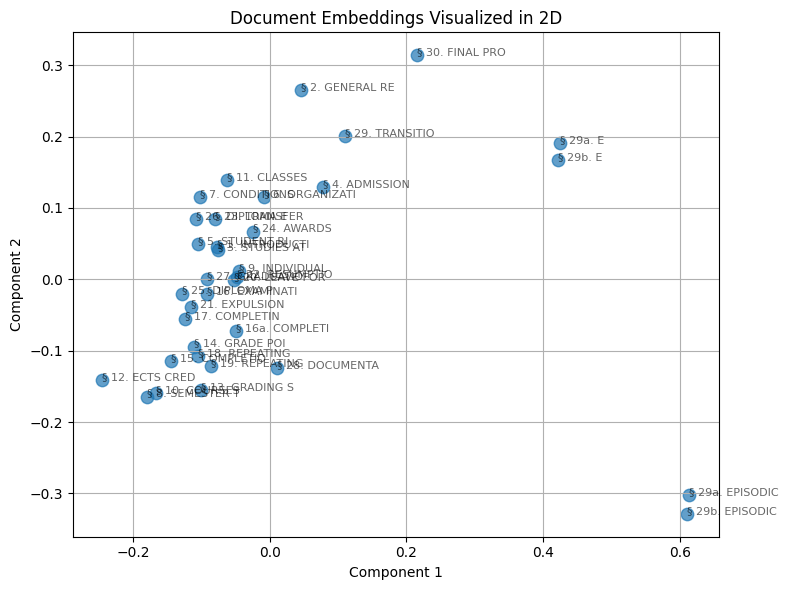

In [60]:
embeddings = np.stack(df['Embedding'].values)
reducer = PCA(n_components=2)

# Method 2: t-SNE (slower, non-linear, better for local structure)
# reducer = TSNE(n_components=2, perplexity=30, random_state=42)

reduced_embeddings = reducer.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, s=80)

for i, title in enumerate(df['Title']):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], title[:15], fontsize=8, alpha=0.6)

plt.title("Document Embeddings Visualized in 2D")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()